# Predict household income from satellite imagery data

First pass.

General ML pipeline steps:
1. Import data
2. Split data into test/train sets
3. Preprocess test/train sets separately
4. Generate features from data
5. For each regressor-hyperparameter combination:
    - Train regressor with given hyperparameters and training data and labels
    - Generate predicted labels for test data with trained regressor
    - Evaluate regressor-hyperparameter performance against actual test labels and get $R^2$
6. Explore best-performing models

In [182]:
import os
import math
import pickle
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn import preprocessing 
from sklearn.metrics import r2_score

# Import configuration file
import config as cf

# Display options 
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = -1

# Turn off big pink warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Import data and drop "future" rows

In [183]:
#DATA_PATH = os.path.join('..', '..', '..', 'Data', 'FinalData', 'BISP', 'bisp_satellite_data_combined_buffer_1km.csv')
DATA_PATH = os.path.join('/Users/robmarty/Dropbox/World Bank/IEs/', 'Pakistan Poverty Estimation from Satellites', 'Data', 'FinalData', 'BISP', 'bisp_satellite_data_combined_buffer_1km.csv')
df = pd.read_csv(DATA_PATH)

# Remove Select Variables
df = df[df.columns.drop(list(df.filter(regex='2011')))]
df = df[df.columns.drop(list(df.filter(regex='2012')))]
df = df[df.columns.drop(list(df.filter(regex='2013')))]
df.shape

(33794, 59)

In [184]:
df = df.loc[df['period'].isin([2011, 2013])]
df = df.loc[df['period'].isin([2013])]
df = df.dropna(axis=0, subset=['hh_inc', 'viirs'])
df = df.dropna()
df.head()

,uid,period,LOCALITY,hh_inc,hh_inc_lastmonth,viirs_2014,viirs_2015,viirs_2016,viirs_2017,viirs_2018,dmspols_1992,dmspols_1993,dmspols_1994,dmspols_1995,dmspols_1996,dmspols_1997,dmspols_1998,dmspols_1999,dmspols_2000,dmspols_2001,dmspols_2002,dmspols_2003,dmspols_2004,dmspols_2005,dmspols_2006,dmspols_2007,dmspols_2008,dmspols_2009,dmspols_2010,viirs,dmspols,l7_1,l7_2,l7_3,l7_4,l7_5,l7_6,l7_7,l7_12,l7_13,l7_14,l7_15,l7_16,l7_17,l7_23,l7_24,l7_25,l7_26,l7_27,l7_34,l7_35,l7_36,l7_37,l7_45,l7_46,l7_47,l7_56,l7_57,l7_67
7,100389,2013,1,73000.0,6000.0,2.089507,2.307763,2.850603,3.653005,3.750000,43.0,33.666667,35.50,45.333333,40.0,33.166667,39.50,40.333333,37.333333,39.666667,38.833333,33.666667,34.00,34.50,40.666667,45.00,43.0,30.333333,46.0,2.141392,45.333333,951.897734,1282.748257,1417.251598,2574.000436,2469.137711,3000.408919,1889.609384,-0.148055,-0.196422,-0.460054,-0.443503,-0.518308,-0.330005,-0.049816,-0.334803,-0.316211,-0.401027,-0.191297,-0.289821,-0.270659,-0.358370,-0.142842,0.020793,-0.076494,0.153327,-0.097133,0.132958,0.227157
8,100401,2013,1,159000.0,13500.0,2.052437,2.296554,2.769960,3.702374,3.488333,43.0,33.666667,35.50,45.333333,40.0,33.166667,39.50,40.333333,37.333333,39.666667,38.833333,33.666667,34.00,34.50,40.666667,45.00,43.0,30.333333,46.0,2.133366,45.333333,941.063694,1268.392009,1402.777070,2547.212362,2463.117111,2998.701940,1876.871453,-0.148149,-0.196990,-0.460442,-0.447113,-0.522274,-0.332090,-0.050309,-0.335155,-0.320172,-0.405501,-0.193459,-0.289731,-0.274281,-0.362588,-0.144556,0.016784,-0.081409,0.151521,-0.098060,0.135080,0.230092
20,101101,2013,1,219000.0,21000.0,2.052437,2.296554,2.769960,3.702374,3.488333,43.0,33.666667,35.50,45.333333,40.0,33.166667,39.50,40.333333,37.333333,39.666667,38.833333,33.666667,34.00,34.50,40.666667,45.00,43.0,30.333333,46.0,2.133366,45.333333,940.979913,1268.248763,1401.871616,2547.740466,2459.946143,2998.786463,1874.074672,-0.148137,-0.196723,-0.460559,-0.446633,-0.522317,-0.331466,-0.050044,-0.335298,-0.319645,-0.405560,-0.192796,-0.290122,-0.273984,-0.362881,-0.144142,0.017532,-0.081320,0.152351,-0.098712,0.135180,0.230811
32,102103,2013,1,148000.0,13000.0,2.052437,2.296554,2.769960,3.702374,3.488333,43.0,33.666667,35.50,45.333333,40.0,33.166667,39.50,40.333333,37.333333,39.666667,38.833333,33.666667,34.00,34.50,40.666667,45.00,43.0,30.333333,46.0,2.133366,45.333333,940.630258,1267.752248,1400.750653,2547.949666,2457.645344,2998.886568,1871.886858,-0.148127,-0.196517,-0.460737,-0.446407,-0.522464,-0.331111,-0.049840,-0.335508,-0.319400,-0.405737,-0.192422,-0.290526,-0.273921,-0.363243,-0.143962,0.018041,-0.081296,0.152961,-0.099191,0.135294,0.231380
40,102237,2013,1,4500.0,88.0,1.968358,2.182109,2.637059,3.357345,3.315000,43.0,32.500000,34.25,43.000000,38.0,31.750000,38.25,38.750000,36.000000,38.250000,37.750000,32.000000,32.75,33.75,40.000000,43.75,42.5,30.000000,45.5,2.023836,44.500000,930.478318,1257.594150,1390.361758,2564.562136,2449.709546,2998.677095,1868.266880,-0.149500,-0.198154,-0.467544,-0.449452,-0.526372,-0.335075,-0.050140,-0.341945,-0.321559,-0.409063,-0.195361,-0.296896,-0.275867,-0.366439,-0.146658,0.022905,-0.078033,0.157077,-0.100758,0.134656,0.232263


## Transform Variables

In [185]:
#df.viirs = np.log(df.viirs+1)
#df.hh_inc = np.log(df.hh_inc+1)




## 2. Split data into test/train

In [186]:
LABEL = 'hh_inc'
TEST_SIZE = 0.3

# Separate feature sets from label sets
x_df = df.drop(labels=[LABEL], axis=1)
scaler = preprocessing.MinMaxScaler() 
scaled_values = scaler.fit_transform(x_df) 
x_df.loc[:,:] = scaled_values

y_df = df[LABEL]

# Split into test and train sets for features and labels
x_train, x_test, y_train, y_test =  train_test_split(x_df, y_df, test_size=TEST_SIZE)

## Define Feature Groups

In [187]:
DAY_FEATURES = df.filter(regex='l7', axis=1).columns.tolist()
DAY_FEATURES_VIIRS = DAY_FEATURES + ['viirs']
DAY_FEATURES_DMSPOLS = DAY_FEATURES + ['dmspols']

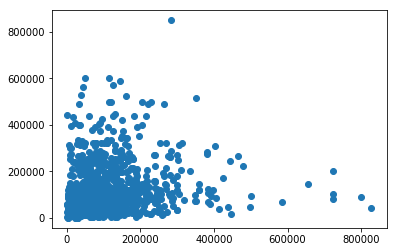

array([[1.        , 0.13502369],
       [0.13502369, 1.        ]])

In [195]:
regressor = DecisionTreeRegressor(max_depth=20)
trained = regressor.fit(x_train[DAY_FEATURES_VIIRS], y_train)
hh_income_predict = trained.predict(x_test[DAY_FEATURES_VIIRS])

from matplotlib import pyplot
pyplot.scatter(y_test, hh_income_predict)
pyplot.show()

np.corrcoef(y_test, hh_income_predict)

## 3. Preprocess data

All vars are numeric - impute missing data with mean

In [7]:
# Check how many rows are missing across columns
print("TRAINING FEATURES MISSING:")
print(pd.isnull(x_train).sum())
print("")
print("TEST FEATURES MISSING:")
print(pd.isnull(x_test).sum())

TRAINING FEATURES MISSING:
dmspols_2011    38
l7_2011_1       0 
l7_2011_2       0 
l7_2011_3       0 
l7_2011_4       0 
l7_2011_5       0 
l7_2011_6       0 
l7_2011_7       0 
viirs_2012      38
dtype: int64

TEST FEATURES MISSING:
dmspols_2011    14
l7_2011_1       0 
l7_2011_2       0 
l7_2011_3       0 
l7_2011_4       0 
l7_2011_5       0 
l7_2011_6       0 
l7_2011_7       0 
viirs_2012      14
dtype: int64


In [8]:
for i in (x_train, x_test):
    for j in i.columns:
        
        if i[j].isnull().sum():
            # Create imputed flag
            new_name = i[j].name + '_imputed'
            i[new_name] = pd.isnull(i[j]).astype('int')
            # Fill with mean
            i[j] = i[j].fillna(i[j].mean())
        else:
            continue

In [9]:
# All missing values were imputed
print("TRAINING FEATURES MISSING:")
print(pd.isnull(x_train).sum())
print("")
print("TEST FEATURES MISSING:")
print(pd.isnull(x_test).sum())

TRAINING FEATURES MISSING:
dmspols_2011            0
l7_2011_1               0
l7_2011_2               0
l7_2011_3               0
l7_2011_4               0
l7_2011_5               0
l7_2011_6               0
l7_2011_7               0
viirs_2012              0
dmspols_2011_imputed    0
viirs_2012_imputed      0
dtype: int64

TEST FEATURES MISSING:
dmspols_2011            0
l7_2011_1               0
l7_2011_2               0
l7_2011_3               0
l7_2011_4               0
l7_2011_5               0
l7_2011_6               0
l7_2011_7               0
viirs_2012              0
dmspols_2011_imputed    0
viirs_2012_imputed      0
dtype: int64


## 4. Feature Generation

[Landsat 7 specs](https://landsat.usgs.gov/sites/default/files/documents/si_product_guide.pdf#page=14)

Create indices from every possible pair of Landsat 7 band.
- Normalized Difference Vegetation Index, NDVI = $\frac{NIR - Red}{NIR + Red}$ is formed from the (NIR, Red) pair.
- Normalized Difference Built-up Index, NDBI = $\frac{SWIR1 - NIR}{SWIR1 + NIR}$ is formed from the (NIR, SWIR1) pair.
- Normalized Difference Water Index, NDWO = $\frac{NIR - SWIR1}{NIR + SWIR1}$ is also formed from the (NIR, SWIR1) pair.
- Modified NDWI, MNDWI = $\frac{Green - SWIR1}{Green + SWIR1}$ is formed from the (NIR, Green) pair. And so on.


| Band | 1 | 2 | 3 | 4 | 5 | 6 | 7
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- 
| 1 | NA 
| 2 | ? | NA 
| 3 | ? | ? | NA 
| 4 | ? | ? | NDVI | NA
| 5 | ? | MNDWI | ? | NDBI, NDWI | NA 
| 6 | ? | ? | ? | ? | ? | NA 
| 7 | ? | ? | ? | ? | ? | ? | NA



In [10]:
# Create ratios 
# Note that ratio of Band A to Band B is the same as ratio of Band B to Band A
# Solution: only create ratios where A < B
for df in (x_train, x_test):
    for i in range(1, 8):
        for j in range(1, 8):

            if i >= j:
                continue
            else:
                band1 = f'l7_2011_{i}'
                band2 = f'l7_2011_{j}'
                new_var = f'ratio_{i}_{j}'
                df[new_var] = abs((df[band1] - df[band2]) / (df[band1] + df[band2]))

In [11]:
x_train.head()

,dmspols_2011,l7_2011_1,l7_2011_2,l7_2011_3,l7_2011_4,l7_2011_5,l7_2011_6,l7_2011_7,viirs_2012,dmspols_2011_imputed,viirs_2012_imputed,ratio_1_2,ratio_1_3,ratio_1_4,ratio_1_5,ratio_1_6,ratio_1_7,ratio_2_3,ratio_2_4,ratio_2_5,ratio_2_6,ratio_2_7,ratio_3_4,ratio_3_5,ratio_3_6,ratio_3_7,ratio_4_5,ratio_4_6,ratio_4_7,ratio_5_6,ratio_5_7,ratio_6_7
358,53.0,1058.988085,1385.168556,1602.108980,2406.603022,2465.198634,3039.765911,2121.646178,5.494750,0,0,0.133453,0.204097,0.388856,0.399017,0.483263,0.334103,0.072621,0.269382,0.280501,0.373926,0.210013,0.200686,0.212202,0.309715,0.139520,0.012028,0.116254,0.062929,0.104373,0.074900,0.177882
2438,6.0,868.614348,1174.826667,1321.466522,2431.912174,2139.191594,3039.880435,1569.171884,0.312616,0,0,0.149851,0.206774,0.473651,0.422427,0.555525,0.287374,0.058743,0.348538,0.290996,0.442511,0.143712,0.295852,0.236292,0.394010,0.085692,0.064037,0.111110,0.215627,0.173909,0.153712,0.319091
4966,0.0,1134.106337,1482.951823,1742.763310,2160.221933,2511.618200,3034.363860,2189.763166,0.129844,0,0,0.133297,0.211569,0.311479,0.377843,0.455864,0.317599,0.080544,0.185901,0.257516,0.343437,0.192449,0.106959,0.180721,0.270372,0.113667,0.075216,0.168279,0.006791,0.094257,0.068460,0.161673
3805,5.0,893.232153,1160.535694,1302.790337,2077.571532,2340.158590,2987.358532,1897.636535,0.326881,0,0,0.130153,0.186500,0.398660,0.447495,0.539641,0.359890,0.057749,0.283201,0.336968,0.440422,0.241027,0.229201,0.284761,0.392660,0.185865,0.059439,0.179625,0.045264,0.121482,0.104423,0.223075
1511,20.0,855.555766,1197.115463,1298.970879,2869.879732,2305.694817,3020.864444,1695.336342,0.643381,0,0,0.166398,0.205806,0.540695,0.458723,0.558585,0.329211,0.040806,0.411302,0.316483,0.432375,0.172249,0.376821,0.279284,0.398602,0.132373,0.109009,0.025631,0.257281,0.134265,0.152550,0.281058


In [12]:
x_test.head()

,dmspols_2011,l7_2011_1,l7_2011_2,l7_2011_3,l7_2011_4,l7_2011_5,l7_2011_6,l7_2011_7,viirs_2012,dmspols_2011_imputed,viirs_2012_imputed,ratio_1_2,ratio_1_3,ratio_1_4,ratio_1_5,ratio_1_6,ratio_1_7,ratio_2_3,ratio_2_4,ratio_2_5,ratio_2_6,ratio_2_7,ratio_3_4,ratio_3_5,ratio_3_6,ratio_3_7,ratio_4_5,ratio_4_6,ratio_4_7,ratio_5_6,ratio_5_7,ratio_6_7
1602,5.500000,839.539600,1140.913113,1211.132724,2883.450827,2225.548448,3011.056571,1528.228169,0.366964,0,0,0.152174,0.181206,0.548997,0.452192,0.563943,0.290860,0.029855,0.432997,0.322189,0.450423,0.145108,0.408422,0.295173,0.426301,0.115755,0.128773,0.021648,0.307190,0.150003,0.185765,0.326666
1966,7.500000,722.351766,1035.490446,1061.942096,2937.096120,2030.396642,3002.826433,1297.845107,0.547749,0,0,0.178138,0.190322,0.605213,0.475178,0.612179,0.284870,0.012611,0.478682,0.324508,0.487167,0.112438,0.468901,0.313179,0.477490,0.099968,0.182527,0.011066,0.387078,0.193202,0.220102,0.396445
3157,16.500000,887.069376,1161.080987,1328.149637,2625.712482,2264.979245,3000.837155,1627.782148,0.832364,0,0,0.133785,0.199114,0.494948,0.437147,0.543678,0.294535,0.067117,0.386774,0.322206,0.442045,0.167345,0.328176,0.260728,0.386392,0.101367,0.073759,0.066670,0.234614,0.139742,0.163688,0.296645
1065,61.000000,1004.152275,1226.656331,1349.472617,2188.364242,2160.560562,3010.192118,1731.231527,6.271641,0,0,0.099741,0.146719,0.370934,0.365407,0.499718,0.265805,0.047675,0.281611,0.275714,0.420958,0.170586,0.237120,0.231077,0.380928,0.123919,0.006393,0.158088,0.116628,0.164315,0.110317,0.269742
793,19.712733,641.214888,439.215760,368.688427,324.121692,255.604827,2936.902443,213.807066,3.548001,1,1,0.186962,0.269854,0.328479,0.429975,0.641591,0.499879,0.087297,0.150777,0.264257,0.739810,0.345177,0.064327,0.181139,0.776930,0.265893,0.118188,0.801215,0.205073,0.839872,0.089043,0.864280


In [13]:
# check that lengths match
print(len(x_train) == len(y_train))
print(len(x_test) == len(y_test))

True
True


### 4.1 Define feature groups

1. Daytime-only: Landsat 7 band data and computed indices
2. Nighttime-only: DMSP and VIIRS data + imputed flags
3. All features

In [14]:
DAY_FEATURES = df.filter(regex='l7|ratio', axis=1).columns.tolist()
NIGHT_FEATURES = ['dmspols_2011', 'viirs_2012', 'dmspols_2011_imputed', 'viirs_2012_imputed']
ALL_FEATURES = df.columns.tolist()

print("Day-only:", DAY_FEATURES)
print("-----")
print("Night-only:", NIGHT_FEATURES)

Day-only: ['l7_2011_1', 'l7_2011_2', 'l7_2011_3', 'l7_2011_4', 'l7_2011_5', 'l7_2011_6', 'l7_2011_7', 'ratio_1_2', 'ratio_1_3', 'ratio_1_4', 'ratio_1_5', 'ratio_1_6', 'ratio_1_7', 'ratio_2_3', 'ratio_2_4', 'ratio_2_5', 'ratio_2_6', 'ratio_2_7', 'ratio_3_4', 'ratio_3_5', 'ratio_3_6', 'ratio_3_7', 'ratio_4_5', 'ratio_4_6', 'ratio_4_7', 'ratio_5_6', 'ratio_5_7', 'ratio_6_7']
-----
Night-only: ['dmspols_2011', 'viirs_2012', 'dmspols_2011_imputed', 'viirs_2012_imputed']


### 4.2 Pickle cleaned data for future use

In [19]:
clean_data = [x_train, x_test, y_train, y_test]

output_path = os.path.join('output', 'final_data.pkl')
with open(output_path, 'wb') as f:
    pickle.dump(obj=clean_data,
                file=f,
                protocol=pickle.HIGHEST_PROTOCOL)

## 5. Train and Evaluate Regressors

### 5.1 Training

In [25]:
# Define a TrainedRegressor object to hold key results information
class TrainedRegressor:
    
    def __init__(self, method, params, features, regressor):
        self.method = method
        self.params = params
        self.regressor = regressor
        self.features = features
    
    def __repr__(self):
        return f'Trained {self.method} on feature set {self.features} with params {self.params}'

In [39]:
# Use GRID_MAIN for full grid search
parameters = cf.GRID_TEST

trained_list = []
count = 0
# print('Training model ', end='')
for i in parameters['regressors']:
    for j in parameters[i]:
        for k in ('DAY_FEATURES', 'NIGHT_FEATURES', 'ALL_FEATURES'):
        
            #print(str(count), end=' ')
            count += 1
            print(f'Model {count}: Training {i} on {k} with params {str(j)}')

            # Initialize regressor, fit data, then append TrainedRegressor object to list
            regressor = eval(i)(**j)
            trained = regressor.fit(x_train[eval(k)], y_train)
            trained_list.append(TrainedRegressor(i, str(j), k, trained))


Model 1: Training LinearRegression on DAY_FEATURES with params {'n_jobs': -1}
Model 2: Training LinearRegression on NIGHT_FEATURES with params {'n_jobs': -1}
Model 3: Training LinearRegression on ALL_FEATURES with params {'n_jobs': -1}
Model 4: Training Lasso on DAY_FEATURES with params {'alpha': 0.01, 'max_iter': 1000.0, 'selection': 'random', 'random_state': 0}
Model 5: Training Lasso on NIGHT_FEATURES with params {'alpha': 0.01, 'max_iter': 1000.0, 'selection': 'random', 'random_state': 0}
Model 6: Training Lasso on ALL_FEATURES with params {'alpha': 0.01, 'max_iter': 1000.0, 'selection': 'random', 'random_state': 0}
Model 7: Training Ridge on DAY_FEATURES with params {'alpha': 0.01, 'max_iter': 1000.0, 'solver': 'cholesky', 'random_state': 0}
Model 8: Training Ridge on NIGHT_FEATURES with params {'alpha': 0.01, 'max_iter': 1000.0, 'solver': 'cholesky', 'random_state': 0}
Model 9: Training Ridge on ALL_FEATURES with params {'alpha': 0.01, 'max_iter': 1000.0, 'solver': 'cholesky', 'r

In [30]:
len(trained_list)

24

### 5.2 Prediction and Evaluation

In [37]:
results_df = pd.DataFrame()
for i in trained_list:
    
    # Get predicted results from test data
    features = eval(i.features)
    pred_labels = i.regressor.predict(x_test[features])
    
    # Append results to dataframe and sort by R^2
    pred_dict = {
        'regressor': i.method,
        'features': i.features,
        'params': i.params,
        'r2': r2_score(y_true=y_test, y_pred=pred_labels)        
    }
    
    results_df = results_df.append(pred_dict, ignore_index=True) \
        .sort_values(by='r2', ascending=False, axis=0) \
        [['regressor', 'params', 'features', 'r2']]

results_df.shape

(24, 4)

In [38]:
results_df

,regressor,params,features,r2
0,DecisionTreeRegressor,"{'criterion': 'mse', 'splitter': 'best', 'max_depth': 1, 'max_features': 'sqrt', 'random_state': 0}",ALL_FEATURES,-0.001394
1,GradientBoostingRegressor,"{'loss': 'ls', 'learning_rate': 0.0001, 'n_estimators': 100, 'criterion': 'mse', 'max_features': 'sqrt', 'random_state': 0}",NIGHT_FEATURES,-0.001550
2,GradientBoostingRegressor,"{'loss': 'ls', 'learning_rate': 0.0001, 'n_estimators': 100, 'criterion': 'mse', 'max_features': 'sqrt', 'random_state': 0}",ALL_FEATURES,-0.001606
3,GradientBoostingRegressor,"{'loss': 'ls', 'learning_rate': 0.0001, 'n_estimators': 100, 'criterion': 'mse', 'max_features': 'sqrt', 'random_state': 0}",DAY_FEATURES,-0.001608
4,Ridge,"{'alpha': 0.01, 'max_iter': 1000.0, 'solver': 'cholesky', 'random_state': 0}",NIGHT_FEATURES,-0.003138
5,Lasso,"{'alpha': 0.01, 'max_iter': 1000.0, 'selection': 'random', 'random_state': 0}",NIGHT_FEATURES,-0.003138
6,LinearRegression,{'n_jobs': -1},NIGHT_FEATURES,-0.003138
7,RandomForestRegressor,"{'n_estimators': 100, 'criterion': 'mse', 'max_depth': 1, 'max_features': 'sqrt', 'n_jobs': -1, 'random_state': 0}",NIGHT_FEATURES,-0.003434
23,RandomForestRegressor,"{'n_estimators': 100, 'criterion': 'mse', 'max_depth': 1, 'max_features': 'sqrt', 'n_jobs': -1, 'random_state': 0}",ALL_FEATURES,-0.004410
8,DecisionTreeRegressor,"{'criterion': 'mse', 'splitter': 'best', 'max_depth': 1, 'max_features': 'sqrt', 'random_state': 0}",NIGHT_FEATURES,-0.004975
